In [55]:
import json
import pandas as pd
from pandas import DataFrame
import numpy as np
import math
from random import random
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from functools import reduce
from tqdm import tqdm
import matplotlib.animation as ani
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import random

In [56]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
plt.style.use('seaborn-dark-palette')
plt.rcParams["mathtext.fontset"] = "cm"
random.seed(12345)
#pd.set_option('display.max_rows', None)

In [57]:
def accuracy_plot(true, pred):
    plt.scatter(true, pred, s = 10, c = -true, cmap='viridis')  
    plt.ylabel('predicted migration intensity(birds km-3)')
    plt.xlabel('actual migration intensity(birds km-3)')
    x = np.arange(0, int(max(true)))
    plt.fill_between(x, x*0.9, x*1.1, alpha = 0.3, where=None, interpolate=False, step=None, data=None)
    plt.show()

In [58]:
class RandomForestModel:
    
    def __init__(self, data, radar):
        self.df_forecasting = data
        self.radar = radar
        #self.coef = coef
        #self.X = X
        #self.y = y
        #self.x_train = self.X[:int(len(self.X)*self.coef)]
        #self.x_valid = self.X[int(len(self.X)*self.coef):]
        #self.y_train = self.X[:int(len(self.y)*self.coef)]
        #self.y_valid = self.X[int(len(self.y)*self.coef):]
    
    def hist_plot(self, index, data, title, x_lab, y_lab):

        rects = plt.bar(x = range(len(data)), height = data, width = 0.8, tick_label = index, color = 'lightskyblue')

        #plt.xticks([index + 0.2 for index in x], label_list)
        plt.ylabel(y_lab)
        plt.title(title)  

        for x,y in enumerate(data):
            plt.text(x, y, "%s"%round(y, 4), fontsize = 15, ha = 'center', va = 'bottom')

        plt.savefig('../figures/bird/%s.png'%title)
        plt.show()

    def line_plot1(self, ts_1, ts_label_1, ts_2, ts_label_2, title, m):

        xs1 = list(range(0, len(ts_1)))
        xs2 = list(range(0, len(ts_2)))

        plt.rcParams['savefig.dpi'] = 300 
        plt.rcParams['figure.dpi'] = 300
        
        plt.ylabel('migration intensity(birds km-3)')
        plt.xlabel('time')

        plt.plot(xs1, ts_1, c = 'forestgreen', label = ts_label_1, lw = 2)
        plt.plot(xs2, ts_2, c = 'red', label = ts_label_2, lw = 2)

        plt.title(title)
        plt.legend(loc = 'upper left')
        plt.savefig('../figures/%s'%m)
        plt.show()

    def line_plot2(self, ts_1, ts_label_1, ts_2, ts_label_2, ts_3, ts_label_3, title, m):
        assert len(ts_1) == len(ts_2)

        xs1 = list(range(0, len(ts_3)))
        xs2 = list(range(len(ts_3), len(ts_3) + len(ts_1)))

        plt.rcParams['savefig.dpi'] = 300 
        plt.rcParams['figure.dpi'] = 300

        plt.plot(xs2, ts_1, c = 'orangered', label = ts_label_1, lw = 1.5)
        plt.plot(xs2, ts_2, c = 'lightskyblue', label = ts_label_2, lw = 1.5)
        plt.plot(xs1, ts_3, c = 'forestgreen', label = ts_label_3, lw = 1.5)

        plt.title(title)
        plt.legend(loc='upper left')
        plt.savefig('../figures/%s'%m)
        plt.show()
    

    def Random_Forest_Model(self, coef, method):
        print(self.df_forecasting)
        self.X = self.df_forecasting.iloc[:,1:]
        self.y = self.df_forecasting.iloc[:,0]
        self.x_train, self.x_valid = self.X[:int(coef * len(self.X))], self.X[int(coef * len(self.X)):]
        self.y_train, self.y_valid = self.y[:int(coef * len(self.y))], self.y[int(coef * len(self.y)):]
        print(len(self.x_train), len(self.x_valid))
        mdl = rf = RandomForestRegressor(n_estimators = 500, random_state=0)
        mdl.fit(self.x_train, self.y_train)
        self.pred = mdl.predict(self.x_valid)
        mae = mean_absolute_error(self.y_valid, self.pred)
        r2 = r2_score(self.y_valid, self.pred)
        var = explained_variance_score(self.y_valid, self.pred)
        self.pred = pd.Series(self.pred, index = self.y_valid.index)

        #self.line_plot1(ts_1 = self.y_valid.values, ts_label_1 = self.radar, ts_2 = self.pred.values, ts_label_2 = '%s - Forecasting'%self.radar, title = '%s forecasting (testing data)'%self.radar, m = method)
        #self.line_plot2(ts_1 = self.y_valid.values, ts_label_1 = '%s observed'%self.radar, ts_2 = self.pred.values, ts_label_2 = '%s - Forecasting'%self.radar, ts_3 = self.y_train.values, ts_label_3 = '%s training'%self.radar, title = '%s forecasting(training + testing)'%self.radar, m = method)
        
        return self.pred, mae, r2, var
    

    def Random_Forest_Model_altitude(self, coef, method, n_esti, rs):
        #print(self.df_forecasting)
        self.X = self.df_forecasting.iloc[:,1:]
        self.y = self.df_forecasting.iloc[:,0]
        self.x_train, self.x_valid = self.X[:int(coef * (len(self.X)/30))*30], self.X[int(coef * (len(self.X)/30))*30:]
        self.y_train, self.y_valid = self.y[:int(coef * (len(self.y)/30))*30], self.y[int(coef * (len(self.y)/30))*30:]
        #print(self.x_train, self.x_valid, self.y_train, self.y_valid)
        mdl = rf = RandomForestRegressor(n_estimators = n_esti, random_state = rs)
        mdl.fit(self.x_train, self.y_train)
        self.pred = mdl.predict(self.x_valid)
        mae = mean_absolute_error(self.y_valid, self.pred)
        r2 = r2_score(self.y_valid, self.pred)
        var = explained_variance_score(self.y_valid, self.pred)
        self.pred = pd.Series(self.pred, index = self.y_valid.index)
        return self.pred

In [59]:
class RFM_Simple_ts(RandomForestModel):
        
    def __init__(self, data, radar):
        self.data = data
        self.radar = radar

        
    #Random Forest Regressor
    def RFR(self):
        self.lags = pd.DataFrame()
        for i in range(10,0,-1):
            self.lags['t-'+str(i)] = self.data.shift(i)
        self.lags['t'] = self.data.values
        self.lags = self.lags[13:]
        self.selection_regressor(self.lags, order = 5)

    def selection_regressor(self, array, order):
        self.lags = array

        X = array.values[:,0:-1]
        y = array.values[:,-1]

        rfe = RFE(RandomForestRegressor(), order)
        fit = rfe.fit(X, y)

        if 't' in self.lags.columns:
            names = self.lags.columns.drop('t')
        else:
            names = self.lags.columns
        self.columns_lags = []
        for i in range(len(fit.support_)):
            if fit.support_[i]:
                self.columns_lags.append(names[i])

        print("Columns with predictive power:", self.columns_lags)
        #return self.columns_lags, self.lags
        

    def Rolling_mean_plot():
        self.line_plot1(ts_1 = self.data, ts_label_1 = radar, ts_2 = data_mean[radar], ts_label_2 = '%s - Rolling Mean'%self.radar, title = 'Rolling Mean')

        
    def df_forecasting_(self):
        self.df_forecasting = pd.DataFrame(self.data)
        for i in self.columns_lags:
            self.df_forecasting[i] = self.lags[i]#df_forecasting[radar].shift(i)
        self.df_forecasting = self.df_forecasting.dropna()
        return self.df_forecasting
    
    def df_forecasting_1(self):
        self.df_forecasting = pd.DataFrame()
        self.df_forecasting[self.radar] = self.data['linear_eta']
        for i in self.columns_lags:
            self.df_forecasting[i] = self.lags[i]#df_forecasting[radar].shift(i)
        self.df_forecasting = self.df_forecasting.dropna()
        return self.df_forecasting
        
    def df_forecasting_mean(self):
        self.df_forecasting = pd.DataFrame(self.data)
        for i in self.columns_lags:
            self.df_forecasting[i] = self.lags[i]#df_forecasting[radar].shift(i)
        self.df_forecasting = self.df_forecasting.dropna()
        self.df_forecasting["%s_rolling"%self.radar] = self.df_forecasting[self.radar].rolling(window = 80).mean()
        self.df_forecasting = self.df_forecasting.dropna()
        return self.df_forecasting

In [60]:
def RFR_weather(data, density, radar, order, step):
    lags = pd.DataFrame()
    for i in range(order,0,-step):
        for col in data.columns:
            lags['t-'+str(i)+'-'+col] = data[col].shift(i)
    for col in data.columns:
        lags[col] = data[col]
    #lags = pd.concat([density, lags], axis = 1)
    lags.dropna(inplace = True)
    #array = lags.values
    return lags

In [61]:
def drop_altitude(data):
    df = []
    for i in tqdm(np.arange(0, len(data), 30)):
        df.append(data[i:i+30].sum())
    return df


def rolling_mean(data, n):
    res = pd.DataFrame(columns=['rolling_mean'])
    #for i in range(n):
    #    res = res.append(pd.DataFrame({'rolling_mean':['']}),ignore_index = True)
    for i in range(n*30, len(data)):
        s = 0
        for j in range(n):
            s = s + data.iloc[i-j*30]
        mean = s/n
        res = res.append(pd.DataFrame({'rolling_mean':[mean]}),ignore_index = True)
    res['ind'] = pd.DataFrame(range(n*30+data.index[0], data.index[0]+len(data)))
    res.set_index('ind', inplace = True)
    #print(res)
    return res

In [62]:
def hyperparameter_tuning(df_forecasting, coef):
    
    print(df_forecasting)
    X = df_forecasting.iloc[:,1:]
    y = df_forecasting.iloc[:,0]
    x_train, x_valid = X[:int(coef * len(X))], X[int(coef * len(X)):]
    y_train, y_valid = y[:int(coef * len(y))], y[int(coef * len(y)):]
    model = RandomForestRegressor()
    
    param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
                  {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},]

    forest_reg = RandomForestRegressor()
    grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
 
    grid_search.fit(x_train, y_train)
    
    print(grid_search.best_params_)
    print(grid_search.best_estimator_)
    
    pred = grid_search.best_estimator_.predict(x_valid)
    pred = pd.Series(pred, index = y_valid.index)
    
    return pred, mae, r2, var

def feature_selection(X, Y):
    rf = RandomForestRegressor()
    rf.fit(X, Y)
    names = X.columns
    print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names),reverse=True))
    


In [63]:
def ReadJson(JsonFile):
    df = pd.DataFrame(columns = ['radar_id', 'n_estimators'])
    with open(JsonFile, 'r') as f:
        i = 0
        for jsonstr in f.readlines(): 
            data = json.loads(jsonstr)
            if i==0:
                lags = int(data['lags'])
                random_state = int(data['random_state'])
            else:
                df = df.append(pd.DataFrame({'radar_id':[data['radar']],'n_estimators':[int(data['n_estimators'])]}),
                                   ignore_index = True)
            i += 1
    return lags, random_state, df

# Import data

In [64]:
weather = pd.read_csv('../dataset/time_weather_filled.csv')
density = pd.read_csv('../dataset/time_filled_AR.csv')
density = density[density.columns.drop('samplingperiod')]
weather = weather[weather.columns.drop('samplingperiod')]
order_lags, random_state, hyperpar = ReadJson('config.json')
#print(weather)

In [65]:
#density.corr()

# Random Forest Model of univariate time series 

### lags

In [ ]:
coef = 0.5
i = 1
radar = 'KABR'
#for radar in tqdm(density.columns):
rfm = RFM_Simple_ts(density[radar], radar)
rfm.RFR()
rfm.df_forecasting_()
rfm.df_forecasting.to_csv('../dataset/features/intensity lags.csv', index = False)
pred, mae, r2, var = rfm.Random_Forest_Model(coef, 'intensity lags')
pred = pd.DataFrame(pred, columns = [radar])
print(mae, r2, var)
#pred.to_csv('../dataset/radar/pred_RF9.csv', index = False)
#print(pred)

Explained variance score: -0.153394
Mean absolute error: 1329.352342


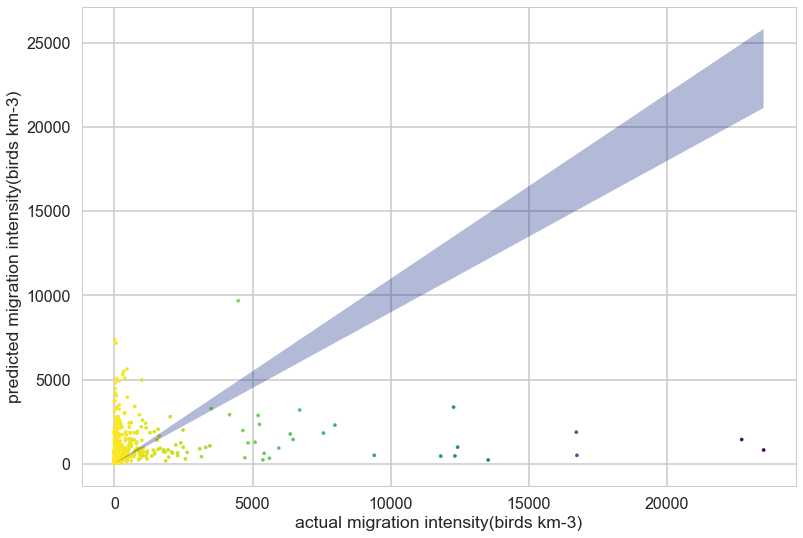

In [21]:
true = density[radar]
true = true[len(true)-len(pred):]
print('Explained variance score: %f'%explained_variance_score(true, pred))
print('Mean absolute error: %f'%mae)
accuracy_plot(true, pred)

### lags, mean

In [22]:
coef = 0.5
i = 1
radar = 'KABR'
#for radar in tqdm(density.columns):
rfm = RFM_Simple_ts(density[radar], radar)
rfm.RFR()
#rfm.Rolling_Mean()
rfm.df_forecasting_mean()
rfm.df_forecasting.to_csv('../dataset/features/lags_mean.csv', index = False)
pred, mae, r2, var = rfm.Random_Forest_Model(coef, 'lags_mean')
pred = pd.DataFrame(pred, columns = [radar])
print(mae, r2, var)

/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Columns with predictive power: ['t-10', 't-9', 't-5', 't-3', 't-1']
           KABR         t-10          t-9          t-5          t-3  \
92     8.393480  2049.189132   994.392557    37.235863   559.133677   
93     4.317992   994.392557   515.290768   378.962660   103.879258   
94    10.596152   515.290768  1152.744335   559.133677  1798.267970   
95     7.572558  1152.744335   250.888712   103.879258     8.393480   
96     6.254167   250.888712    37.235863  1798.267970     4.317992   
..          ...          ...          ...          ...          ...   
915  183.349949   112.543461   569.722786   201.459805   402.122239   
916  128.136609   569.722786   726.379991  1542.050455  1148.371131   
917   45.435735   726.379991   120.285667   402.122239   167.986873   
918   63.814922   120.285667  6367.203030  1148.371131   183.349949   
919  162.604766  6367.203030   201.459805   167.986873   128.136609   

             t-1  KABR_rolling  
92   1798.267970   1464.448738  
93      8.393

Explained variance score: -0.033287
Mean absolute error: 1188.782892


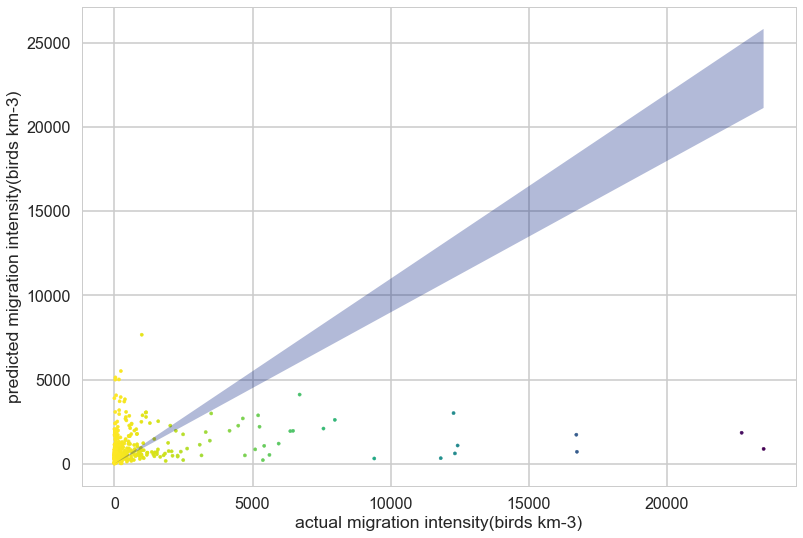

In [23]:
true = density[radar]
true = true[len(true)-len(pred):]
print('Explained variance score: %f'%explained_variance_score(true, pred))
print('Mean absolute error: %f'%mae)
accuracy_plot(true, pred)

# Random Forest Model with pass weather information

### weather t

In [24]:
coef = 0.5
radar = 'KABR'
i = 1
#for radar in tqdm(density.columns):
w = weather[weather['radar_id'] == radar][weather.columns.drop('radar_id')]
w.reset_index(drop = True, inplace = True)
df_forecasting = pd.concat([density[radar], w], axis = 1)
print(df_forecasting)
rfm = RandomForestModel(df_forecasting, radar)
rfm.df_forecasting.to_csv('../dataset/features/weather.csv', index = False)
pred, mae, r2, var = rfm.Random_Forest_Model(coef, 'weather')
pred = pd.DataFrame(pred, columns = [radar])
print(mae, r2, var)

           KABR     uwind     vwind        air  pressure.sfc  \
0     13.541490 -3.588886 -1.039522  -2.446717   97421.43750   
1     17.167515 -4.070577  5.809257   0.240159   95660.32813   
2     15.164654  3.136525 -7.787172  -3.911338   97113.50000   
3     37.477398 -1.819942  3.179482  -7.147056   96890.96875   
4    215.851449 -0.611198 -8.128205  -2.213782   96166.08594   
..          ...       ...       ...        ...           ...   
915  183.349949  2.967651  0.553424  14.876612   96201.71094   
916  128.136609  4.235021  3.104872  16.024527   96244.23438   
917   45.435735  4.724177 -5.540771  12.828629   96370.48438   
918   63.814922  2.245199 -2.122562  12.484832   96826.19531   
919  162.604766  1.466839 -2.683448  13.605868   96927.41406   

     relative.humidity     omega  total.cloud.cover   visibility  \
0            73.109375  0.200119              16.25  20009.20508   
1            91.569649 -0.224435              29.50  16459.50244   
2            73.326698 -0.0

Explained variance score: -0.320239
Mean absolute error: 1064.125155


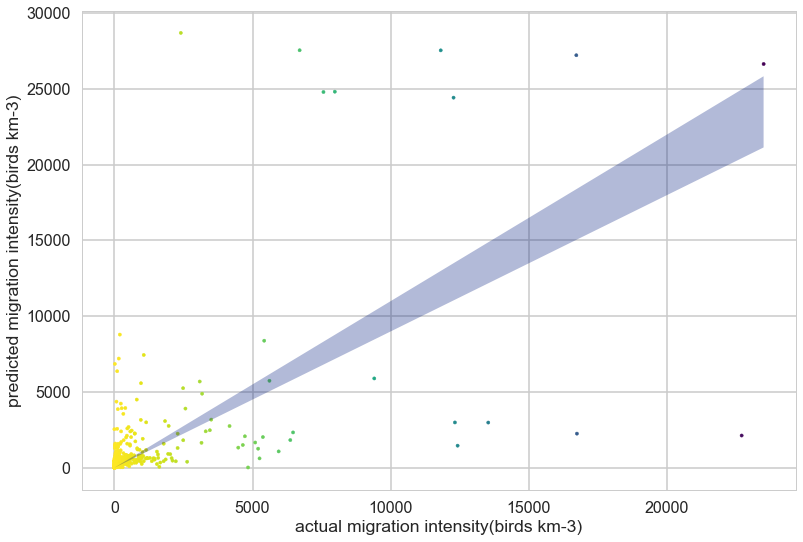

In [25]:
true = density[radar]
true = true[len(true)-len(pred):]
print('Explained variance score: %f'%explained_variance_score(true, pred))
print('Mean absolute error: %f'%mae)
accuracy_plot(true, pred)

### weather and intensity lags (t-2) selected

In [26]:
coef = 0.5
radar = 'KABR'
i = 1
#for radar in tqdm(density.columns):
w = weather[weather['radar_id'] == radar][weather.columns.drop('radar_id')]
w.reset_index(drop = True, inplace = True)
df_forecasting = pd.concat([density[radar], w], axis = 1)
df_forecasting = RFR_weather(df_forecasting, density[radar], radar, order = 2, step = 1)
print(df_forecasting)
rfm = RFM_Simple_ts(density[radar], radar)
#rfm.Rolling_Mean()
rfm.selection_regressor(df_forecasting, order = 10)
rfm.df_forecasting_()
rfm.df_forecasting.to_csv('../dataset/features/weather_lags2_selected.csv', index = False)
pred, mae, r2, var = rfm.Random_Forest_Model(coef, 'weather_lags2_selected')
pred = pd.DataFrame(pred, columns = [radar])
print(mae, r2, var)
#print(pred)
#pred.to_csv('../dataset/radar/pred_RF8.csv', index = False)

        t-2-KABR  t-2-uwind  t-2-vwind    t-2-air  t-2-pressure.sfc  \
2      13.541490  -3.588886  -1.039522  -2.446717       97421.43750   
3      17.167515  -4.070577   5.809257   0.240159       95660.32813   
4      15.164654   3.136525  -7.787172  -3.911338       97113.50000   
5      37.477398  -1.819942   3.179482  -7.147056       96890.96875   
6     215.851449  -0.611198  -8.128205  -2.213782       96166.08594   
..           ...        ...        ...        ...               ...   
915  1148.371131  -3.266900   8.859827  12.709631       95307.57031   
916   167.986873   3.921422  -0.303300  18.564879       95563.76563   
917   183.349949   2.967651   0.553424  14.876612       96201.71094   
918   128.136609   4.235021   3.104872  16.024527       96244.23438   
919    45.435735   4.724177  -5.540771  12.828629       96370.48438   

     t-2-relative.humidity  t-2-omega  t-2-total.cloud.cover  t-2-visibility  \
2                73.109375   0.200119                  16.25     20

/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Columns with predictive power: ['t-2-KABR', 't-2-air', 't-1-air', 't-1-visibility', 'KABR', 'uwind', 'vwind', 'air', 'pressure.sfc', 'total.cloud.cover']
            KABR     t-2-KABR    t-2-air    t-1-air  t-1-visibility     uwind  \
2      15.164654    13.541490  -2.446717   0.240159     16459.50244  3.136525   
3      37.477398    17.167515   0.240159  -3.911338     20006.86133 -1.819942   
4     215.851449    15.164654  -3.911338  -7.147056     20006.53516 -0.611198   
5    2884.477218    37.477398  -7.147056  -2.213782     18406.58398  0.303173   
6       3.992153   215.851449  -2.213782  -5.924112     19507.30469 -0.779900   
..           ...          ...        ...        ...             ...       ...   
915   183.349949  1148.371131  12.709631  18.564879     20010.19531  2.967651   
916   128.136609   167.986873  18.564879  14.876612     20007.16602  4.235021   
917    45.435735   183.349949  14.876612  16.024527     18557.70337  4.724177   
918    63.814922   128.136609  16.02

Explained variance score: -0.042639
Mean absolute error: 1078.348107


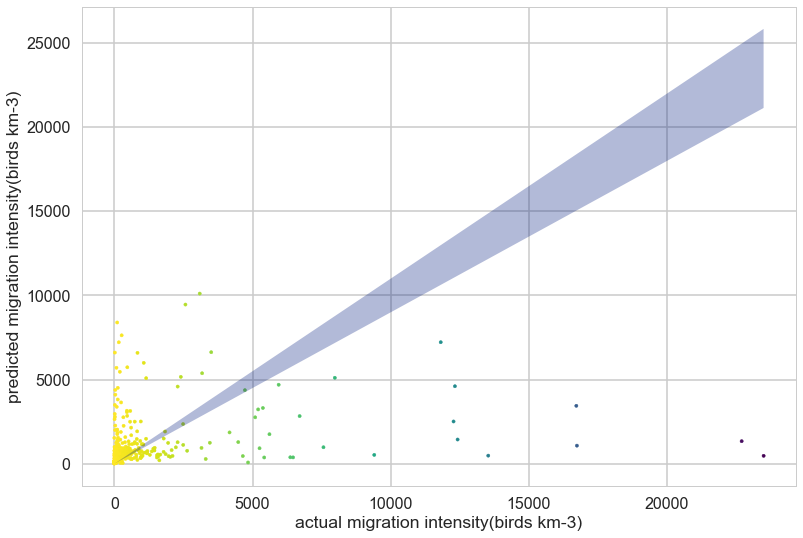

In [27]:
true = density[radar]
true = true[len(true)-len(pred):]
print('Explained variance score: %f'%explained_variance_score(true, pred))
print('Mean absolute error: %f'%mean_absolute_error(true, pred))
accuracy_plot(true, pred)

### weather and intensity lags(t-2)

In [28]:
coef = 0.5
radar = 'KABR'
i = 1
#weather = pd.read_csv('../dataset/radar/time_weather_filled_%s.csv'%radar)
#for radar in tqdm(density.columns):
w = weather[weather['radar_id'] == radar][weather.columns.drop(['radar_id'])]
w.reset_index(drop = True, inplace = True)
w = pd.concat([density[radar], w], axis = 1)
df_forecasting = RFR_weather(w, density[radar], radar, order = 2, step = 1)
df_forecasting.set_index(radar, inplace = True)
df_forecasting.reset_index(inplace = True, drop = False)
rfm = RandomForestModel(df_forecasting, radar)
rfm.df_forecasting = df_forecasting
rfm.df_forecasting.to_csv('../dataset/features/weather_lags2.csv', index = False)
pred, mae, r2, var = rfm.Random_Forest_Model(coef, 'weather_lags5.csv')
print(mae, r2, var)

            KABR     t-2-KABR  t-2-uwind  t-2-vwind    t-2-air  \
0      15.164654    13.541490  -3.588886  -1.039522  -2.446717   
1      37.477398    17.167515  -4.070577   5.809257   0.240159   
2     215.851449    15.164654   3.136525  -7.787172  -3.911338   
3    2884.477218    37.477398  -1.819942   3.179482  -7.147056   
4       3.992153   215.851449  -0.611198  -8.128205  -2.213782   
..           ...          ...        ...        ...        ...   
913   183.349949  1148.371131  -3.266900   8.859827  12.709631   
914   128.136609   167.986873   3.921422  -0.303300  18.564879   
915    45.435735   183.349949   2.967651   0.553424  14.876612   
916    63.814922   128.136609   4.235021   3.104872  16.024527   
917   162.604766    45.435735   4.724177  -5.540771  12.828629   

     t-2-pressure.sfc  t-2-relative.humidity  t-2-omega  \
0         97421.43750              73.109375   0.200119   
1         95660.32813              91.569649  -0.224435   
2         97113.50000         

### weather and intensity lags(t-5) 

In [29]:
coef = 0.5
radar = 'KABR'
i = 1
#weather = pd.read_csv('../dataset/radar/time_weather_filled_%s.csv'%radar)
#for radar in tqdm(density.columns):
w = weather[weather['radar_id'] == radar][weather.columns.drop(['radar_id'])]
w.reset_index(drop = True, inplace = True)
w = pd.concat([density[radar], w], axis = 1)
df_forecasting = RFR_weather(w, density[radar], radar, order = 5, step = 1)
df_forecasting.set_index(radar, inplace = True)
df_forecasting.reset_index(inplace = True, drop = False)


In [30]:
rfm = RandomForestModel(df_forecasting, radar)
#rfm.Rolling_Mean()
"""
df_density = rfm.df_forecasting_()
rfm.selection_regressor(df_forecasting, order = 10)
df_forecasting = rfm.df_forecasting_()
for c in df_density.columns:
    df_forecasting[c] = df_density[c]
"""
rfm.df_forecasting = df_forecasting
rfm.df_forecasting.to_csv('../dataset/features/weather_lags5.csv', index = False)
pred, mae, r2, var = rfm.Random_Forest_Model(coef, 'weather_lags5.csv')
print(mae, r2, var)
#pred = pd.DataFrame(pred, columns = [radar])
#print(pred)
#pred.to_csv('../dataset/radar/pred_RF8.csv', index = False)

            KABR     t-5-KABR  t-5-uwind  t-5-vwind    t-5-air  \
0    2884.477218    13.541490  -3.588886  -1.039522  -2.446717   
1       3.992153    17.167515  -4.070577   5.809257   0.240159   
2       4.701654    15.164654   3.136525  -7.787172  -3.911338   
3      23.016916    37.477398  -1.819942   3.179482  -7.147056   
4      13.416129   215.851449  -0.611198  -8.128205  -2.213782   
..           ...          ...        ...        ...        ...   
910   183.349949   201.459805   4.044722   1.824882  11.234711   
911   128.136609  1542.050455   0.238368  -3.796220   9.837277   
912    45.435735   402.122239   0.306659  -2.873338   9.889106   
913    63.814922  1148.371131  -3.266900   8.859827  12.709631   
914   162.604766   167.986873   3.921422  -0.303300  18.564879   

     t-5-pressure.sfc  t-5-relative.humidity  t-5-omega  \
0         97421.43750              73.109375   0.200119   
1         95660.32813              91.569649  -0.224435   
2         97113.50000         

Explained variance score: -0.222427
Mean absolute error: 1065.031897


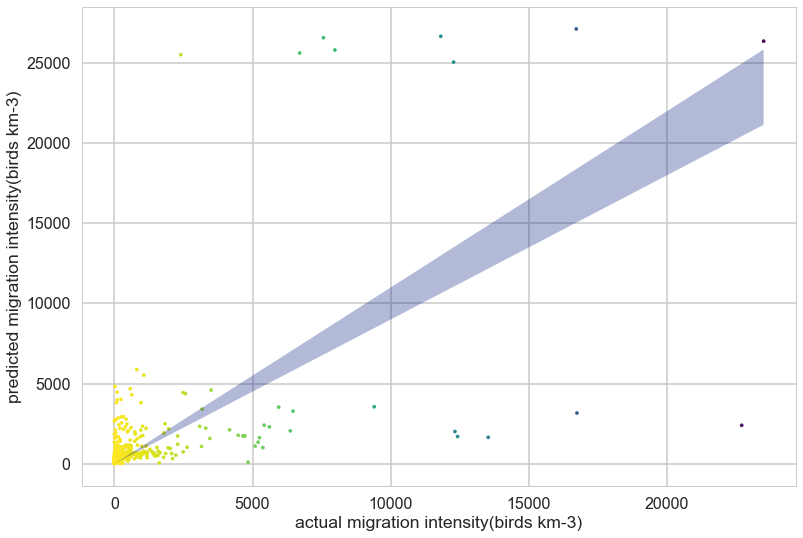

In [31]:
true = density[radar]
true = true[len(true)-len(pred):]
print('Explained variance score: %f'%explained_variance_score(true, pred))
print('Mean absolute error: %f'%mean_absolute_error(true, pred))
accuracy_plot(true, pred)

### weather and intensity lags(t-5) selected

In [32]:
coef = 0.5
radar = 'KABR'
i = 1
#for radar in tqdm(density.columns):
w = weather[weather['radar_id'] == radar][weather.columns.drop('radar_id')]
w.reset_index(drop = True, inplace = True)
df_forecasting = pd.concat([density[radar], w], axis = 1)
df_forecasting = RFR_weather(df_forecasting, density[radar], radar, order = 5, step = 1)
print(df_forecasting)
rfm = RFM_Simple_ts(density[radar], radar)
#rfm.Rolling_Mean()
rfm.selection_regressor(df_forecasting, order = 10)
rfm.df_forecasting_()
rfm.df_forecasting.to_csv('../dataset/features/weather_lags5_selected.csv', index = False)
pred, mae, r2, var = rfm.Random_Forest_Model(coef, 'weather_lags5_selected')
pred = pd.DataFrame(pred, columns = [radar])
print(mae, r2, var)

        t-5-KABR  t-5-uwind  t-5-vwind    t-5-air  t-5-pressure.sfc  \
5      13.541490  -3.588886  -1.039522  -2.446717       97421.43750   
6      17.167515  -4.070577   5.809257   0.240159       95660.32813   
7      15.164654   3.136525  -7.787172  -3.911338       97113.50000   
8      37.477398  -1.819942   3.179482  -7.147056       96890.96875   
9     215.851449  -0.611198  -8.128205  -2.213782       96166.08594   
..           ...        ...        ...        ...               ...   
915   201.459805   4.044722   1.824882  11.234711       96555.81250   
916  1542.050455   0.238368  -3.796220   9.837277       96551.39063   
917   402.122239   0.306659  -2.873338   9.889106       96488.40625   
918  1148.371131  -3.266900   8.859827  12.709631       95307.57031   
919   167.986873   3.921422  -0.303300  18.564879       95563.76563   

     t-5-relative.humidity  t-5-omega  t-5-total.cloud.cover  t-5-visibility  \
5                73.109375   0.200119                  16.25    200

/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Columns with predictive power: ['t-5-visibility', 't-2-KABR', 't-1-air', 't-1-visibility', 'KABR', 'uwind', 'vwind', 'air', 'pressure.sfc', 'total.cloud.cover']
            KABR  t-5-visibility     t-2-KABR    t-1-air  t-1-visibility  \
5    2884.477218    20009.205080    37.477398  -2.213782     18406.58398   
6       3.992153    16459.502440   215.851449  -5.924112     19507.30469   
7       4.701654    20006.861330  2884.477218 -16.131893     20009.75586   
8      23.016916    20006.535160     3.992153 -13.304755     16358.66797   
9      13.416129    18406.583980     4.701654  -5.292902     20008.30469   
..           ...             ...          ...        ...             ...   
915   183.349949    20008.195310  1148.371131  18.564879     20010.19531   
916   128.136609     8009.598877   167.986873  14.876612     20007.16602   
917    45.435735    20007.689450   183.349949  16.024527     18557.70337   
918    63.814922    20009.894530   128.136609  12.828629     20008.73633   
919

### weather and intensity lags(t-2), mean

In [33]:
coef = 0.5
radar = 'KABR'
i = 1
#for radar in tqdm(density.columns):
w = weather[weather['radar_id'] == radar][weather.columns.drop('radar_id')]
w.reset_index(drop = True, inplace = True)
df_forecasting = pd.concat([density[radar], w], axis = 1)
df_forecasting = RFR_weather(df_forecasting, density[radar], radar, order = 2, step = 1)
print(df_forecasting)
rfm = RFM_Simple_ts(density[radar], radar)
#rfm.Rolling_Mean()
rfm.selection_regressor(df_forecasting, order = 10)
rfm.df_forecasting_mean()
rfm.df_forecasting.to_csv('../dataset/features/weather_lags2_mean.csv', index = False)
pred, mae, r2, var = rfm.Random_Forest_Model(coef, 'weather_lags2_mean')
pred = pd.DataFrame(pred, columns = [radar])
print(mae, r2, var)

        t-2-KABR  t-2-uwind  t-2-vwind    t-2-air  t-2-pressure.sfc  \
2      13.541490  -3.588886  -1.039522  -2.446717       97421.43750   
3      17.167515  -4.070577   5.809257   0.240159       95660.32813   
4      15.164654   3.136525  -7.787172  -3.911338       97113.50000   
5      37.477398  -1.819942   3.179482  -7.147056       96890.96875   
6     215.851449  -0.611198  -8.128205  -2.213782       96166.08594   
..           ...        ...        ...        ...               ...   
915  1148.371131  -3.266900   8.859827  12.709631       95307.57031   
916   167.986873   3.921422  -0.303300  18.564879       95563.76563   
917   183.349949   2.967651   0.553424  14.876612       96201.71094   
918   128.136609   4.235021   3.104872  16.024527       96244.23438   
919    45.435735   4.724177  -5.540771  12.828629       96370.48438   

     t-2-relative.humidity  t-2-omega  t-2-total.cloud.cover  t-2-visibility  \
2                73.109375   0.200119                  16.25     20

/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Columns with predictive power: ['t-2-KABR', 't-2-air', 't-1-air', 't-1-visibility', 'KABR', 'uwind', 'vwind', 'air', 'pressure.sfc', 'total.cloud.cover']
            KABR     t-2-KABR    t-2-air    t-1-air  t-1-visibility     uwind  \
81    480.961224  2217.717447   8.003335  10.800788     20010.18359 -3.364436   
82   2049.189132   477.485776  10.800788   9.403535     20009.29492 -5.222651   
83    994.392557   480.961224   9.403535  10.946290     20006.75195 -6.607782   
84    515.290768  2049.189132  10.946290  11.910456     20008.77930 -6.273430   
85   1152.744335   994.392557  11.910456  11.997945     20008.65820 -0.954413   
..           ...          ...        ...        ...             ...       ...   
915   183.349949  1148.371131  12.709631  18.564879     20010.19531  2.967651   
916   128.136609   167.986873  18.564879  14.876612     20007.16602  4.235021   
917    45.435735   183.349949  14.876612  16.024527     18557.70337  4.724177   
918    63.814922   128.136609  16.02

Explained variance score: 0.130037
Mean absolute error: 1008.963457


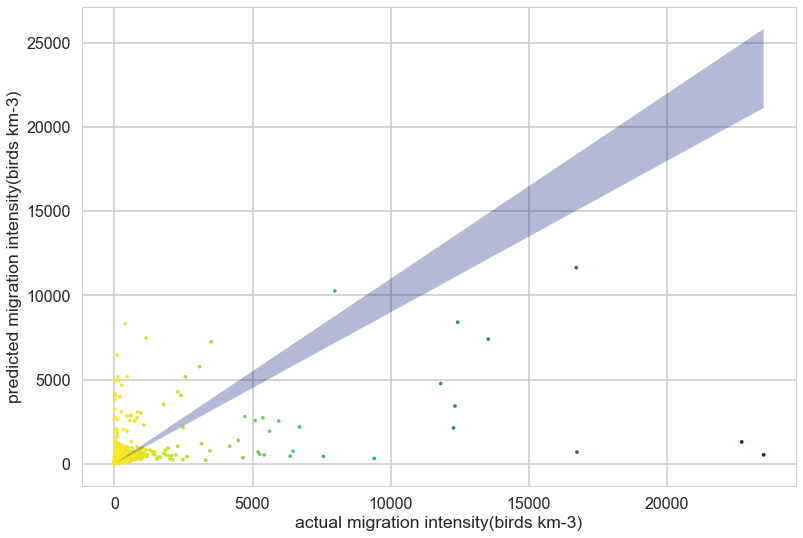

In [34]:
true = density[radar]
true = true[len(true)-len(pred):]
print('Explained variance score: %f'%explained_variance_score(true, pred))
print('Mean absolute error: %f'%mean_absolute_error(true, pred))
accuracy_plot(true, pred)

### weather and intensity lags(t-5), mean

In [35]:
coef = 0.5
radar = 'KABR'
i = 1
#for radar in tqdm(density.columns):
w = weather[weather['radar_id'] == radar][weather.columns.drop('radar_id')]
w.reset_index(drop = True, inplace = True)
df_forecasting = pd.concat([density[radar], w], axis = 1)
df_forecasting = RFR_weather(df_forecasting, density[radar], radar, order = 5, step = 1)
print(df_forecasting)
rfm = RFM_Simple_ts(density[radar], radar)
#rfm.Rolling_Mean()
rfm.selection_regressor(df_forecasting, order = 10)
rfm.df_forecasting_mean()
rfm.df_forecasting.to_csv('../dataset/features/weather_lags5_mean.csv', index = False)
pred, mae, r2, var = rfm.Random_Forest_Model(coef, 'weather_lags5_mean')
pred = pd.DataFrame(pred, columns = [radar])
print(mae, r2, var)

        t-5-KABR  t-5-uwind  t-5-vwind    t-5-air  t-5-pressure.sfc  \
5      13.541490  -3.588886  -1.039522  -2.446717       97421.43750   
6      17.167515  -4.070577   5.809257   0.240159       95660.32813   
7      15.164654   3.136525  -7.787172  -3.911338       97113.50000   
8      37.477398  -1.819942   3.179482  -7.147056       96890.96875   
9     215.851449  -0.611198  -8.128205  -2.213782       96166.08594   
..           ...        ...        ...        ...               ...   
915   201.459805   4.044722   1.824882  11.234711       96555.81250   
916  1542.050455   0.238368  -3.796220   9.837277       96551.39063   
917   402.122239   0.306659  -2.873338   9.889106       96488.40625   
918  1148.371131  -3.266900   8.859827  12.709631       95307.57031   
919   167.986873   3.921422  -0.303300  18.564879       95563.76563   

     t-5-relative.humidity  t-5-omega  t-5-total.cloud.cover  t-5-visibility  \
5                73.109375   0.200119                  16.25    200

/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Columns with predictive power: ['t-5-visibility', 't-2-KABR', 't-1-air', 't-1-visibility', 'KABR', 'uwind', 'vwind', 'air', 'pressure.sfc', 'total.cloud.cover']
            KABR  t-5-visibility     t-2-KABR    t-1-air  t-1-visibility  \
84    515.290768    18211.848170  2049.189132  11.910456     20008.77930   
85   1152.744335    20010.183590   994.392557  11.997945     20008.65820   
86    250.888712    20009.294920   515.290768  18.419493     20009.93359   
87     37.235863    20006.751950  1152.744335  14.508490     20009.38867   
88    378.962660    20008.779300   250.888712   9.453933     20006.27539   
..           ...             ...          ...        ...             ...   
915   183.349949    20008.195310  1148.371131  18.564879     20010.19531   
916   128.136609     8009.598877   167.986873  14.876612     20007.16602   
917    45.435735    20007.689450   183.349949  16.024527     18557.70337   
918    63.814922    20009.894530   128.136609  12.828629     20008.73633   
919

### weather and intensity lags(t-5) with altitude

In [ ]:
coef = 0.5
radar = 'KABR'
weather = pd.read_csv('../dataset/time_weather_filled_%s.csv'%radar)

In [ ]:
i = 1
#for radar in tqdm(density.columns):
w = weather[weather.columns.drop(['radar_id', 'samplingperiod', 'hgt'])]
w.reset_index(drop = True, inplace = True)
df_forecasting = RFR_weather(w, weather[['linear_eta']], radar, order = 150, step = 30)
df_forecasting.set_index('linear_eta', inplace = True)
df_forecasting.reset_index(inplace = True, drop = False)
print(df_forecasting)
df_forecasting.to_csv('../dataset/regressor.csv', index = False)

In [ ]:
rfm = RandomForestModel(df_forecasting, radar)
pred = rfm.Random_Forest_Model_altitude(coef, 'weather_lags5')

In [ ]:
print(len(pred))
pred_y = drop_altitude(pred.values)
print(len(pred_y))
true = drop_altitude(df_forecasting['linear_eta'].values)
test_y = true[(len(true)-len(pred_y)):]
train_y = true[:(len(true)-len(pred_y))]
rfm.line_plot1(ts_1 = test_y, ts_label_1 = rfm.radar, ts_2 = pred_y, ts_label_2 = '%s - Forecasting'%rfm.radar, title = '%s forecasting (testing data)'%rfm.radar, m = 'weather_lags5')
rfm.line_plot2(ts_1 = test_y, ts_label_1 = '%s observed'%rfm.radar, ts_2 = pred_y, ts_label_2 = '%s - Forecasting'%rfm.radar, ts_3 = train_y, ts_label_3 = '%s training'%rfm.radar, title = '%s forecasting(training + testing)'%rfm.radar, m = 'weather_lags5')
var = explained_variance_score(test_y, pred_y)
mae = mean_absolute_error(test_y, pred_y)
r2 = r2_score(test_y, pred_y)
print(mae, r2, var)

In [ ]:
n = df_forecasting.shape[0]
p = df_forecasting.shape[1]-1
print(1-((1-r2)*(n-1))/(n-p-1))

### weather and intensity lags(t-5) with altitude, mean

In [ ]:
coef = 0.5
radar = 'KABR'
weather = pd.read_csv('../dataset/time_weather_filled_%s.csv'%radar)
i = 1
#for radar in tqdm(density.columns):
w = weather[weather.columns.drop(['radar_id', 'samplingperiod', 'hgt'])]
w.reset_index(drop = True, inplace = True)
df_forecasting = RFR_weather(w, weather[['linear_eta']], radar, order = 150, step = 30)
df_forecasting["rolling_mean"] = df_forecasting['linear_eta'].rolling(window = 80).mean()
df_forecasting = df_forecasting.dropna()

df_forecasting.set_index('linear_eta', inplace = True)
df_forecasting.reset_index(inplace = True, drop = False)
print(df_forecasting)
df_forecasting.to_csv('../dataset/regressor_mean.csv', index = False)
rfm = RandomForestModel(df_forecasting, radar)
pred = rfm.Random_Forest_Model_altitude(coef, 'weather_lags5_mean')

In [ ]:
print(len(pred))
pred_y = drop_altitude(pred.values)
print(len(pred_y))
true = drop_altitude(df_forecasting['linear_eta'].values)
test_y = true[(len(true)-len(pred_y)):]
train_y = true[:(len(true)-len(pred_y))]
rfm.line_plot1(ts_1 = test_y, ts_label_1 = rfm.radar, ts_2 = pred_y, ts_label_2 = '%s - Forecasting'%rfm.radar, title = '%s forecasting (testing data)'%rfm.radar, m = 'weather_lags5')
rfm.line_plot2(ts_1 = test_y, ts_label_1 = '%s observed'%rfm.radar, ts_2 = pred_y, ts_label_2 = '%s - Forecasting'%rfm.radar, ts_3 = train_y, ts_label_3 = '%s training'%rfm.radar, title = '%s forecasting(training + testing)'%rfm.radar, m = 'weather_lags5')
var = explained_variance_score(test_y, pred_y)
mae = mean_absolute_error(test_y, pred_y)
r2 = r2_score(test_y, pred_y)
print(var, mae, r2)

### weather with altitude and mean

In [72]:
radars = pd.read_csv('../dataset/radar.csv').values.reshape(1, -1)
radars = radars[0]
print(radars)

['KABR' 'KABX' 'KAKQ' 'KAMA' 'KAMX' 'KAPX' 'KARX' 'KATX' 'KBBX' 'KBGM'
 'KBHX' 'KBIS' 'KBLX' 'KBMX' 'KBOX' 'KBRO' 'KBUF' 'KBYX' 'KCAE' 'KCBW'
 'KCBX' 'KCCX' 'KCLE' 'KCLX' 'KCRP' 'KCXX' 'KCYS' 'KDAX' 'KDDC' 'KDFX'
 'KDGX' 'KDIX' 'KDLH' 'KDMX' 'KDOX' 'KDTX' 'KDVN' 'KDYX' 'KEAX' 'KEMX'
 'KENX' 'KEPZ' 'KESX' 'KEVX' 'KEWX' 'KEYX' 'KFCX' 'KFDR' 'KFDX' 'KFFC'
 'KFSD' 'KFSX' 'KFTG' 'KFWS' 'KGGW' 'KGJX' 'KGLD' 'KGRB' 'KGRK' 'KGRR'
 'KGSP' 'KGWX' 'KGYX' 'KHDX' 'KHGX' 'KHNX' 'KHTX' 'KICT' 'KICX' 'KILN'
 'KILX' 'KIND' 'KINX' 'KIWA' 'KIWX' 'KJAX' 'KJGX' 'KJKL' 'KLBB' 'KLCH'
 'KLIX' 'KLNX' 'KLOT' 'KLRX' 'KLSX' 'KLTX' 'KLVX' 'KLWX' 'KLZK' 'KMAF'
 'KMAX' 'KMHX' 'KMKX' 'KMLB' 'KMOB' 'KMPX' 'KMQT' 'KMRX' 'KMSX' 'KMTX'
 'KMUX' 'KMVX' 'KNKX' 'KNQA' 'KOAX' 'KOHX' 'KOKX' 'KOTX' 'KPAH' 'KPBZ'
 'KPDT' 'KPUX' 'KRAX' 'KRGX' 'KRIW' 'KRLX' 'KRTX' 'KSFX' 'KSGF' 'KSHV'
 'KSJT' 'KSOX' 'KSRX' 'KTBW' 'KTFX' 'KTLH' 'KTLX' 'KTWX' 'KTYX' 'KUDX'
 'KUEX' 'KVNX' 'KVTX' 'KVWX' 'KYUX']


In [78]:
coef = 0.5
radar = 'KABR'
for radar in tqdm(radars):
    weather = pd.read_csv('../dataset/weather_filled1/time_weather_filled_%s.csv'%radar)
    order_lags = 3
    
    w = weather[weather.columns.drop(['radar_id', 'samplingperiod', 'hgt'])]
    w.reset_index(drop = True, inplace = True)

    rm = rolling_mean(w['linear_eta'], 10)
    df_forecasting = RFR_weather(w, weather[['linear_eta']], radar, order = 30*order_lags, step = 30)
    df_forecasting['rolling_mean'] = rm
    df_forecasting = df_forecasting.dropna()
    df_forecasting.set_index('linear_eta', inplace = True)
    df_forecasting.reset_index(inplace = True, drop = False)
    df_forecasting.to_csv('../dataset/regressor_mean1/regressor_mean%i_%s.csv'%(order_lags, radar), index = False)

100%|██████████| 135/135 [32:33<00:00, 14.47s/it]


In [67]:
coef = 0.5
radar = 'KABR'
radars = ['KRIW']
for radar in radars:
    weather = pd.read_csv('../dataset/weather_filled/time_weather_filled_%s.csv'%radar)
    
    w = weather[weather.columns.drop(['radar_id', 'samplingperiod', 'hgt'])]
    w.reset_index(drop = True, inplace = True)

    rm = rolling_mean(w['linear_eta'], 10)
    df_forecasting = RFR_weather(w, weather[['linear_eta']], radar, order = 30*order_lags, step = 30)
    #print(len(df_forecasting))
    df_forecasting['rolling_mean'] = rm
    #print(len(df_forecasting))
    df_forecasting = df_forecasting.dropna()
    df_forecasting.set_index('linear_eta', inplace = True)
    df_forecasting.reset_index(inplace = True, drop = False)
    df_forecasting.to_csv('../dataset/regressor_mean/regressor_mean%i_%s.csv'%(order_lags, radar), index = False)

In [53]:
coef = 0.5
#result = pd.DataFrame(columns=('lag','explained_variance','mae','r2'))
for radar in radars:
    df_forecasting = pd.read_csv('../dataset/regressor_mean/regressor_mean%i_%s.csv'%(order_lags, radar))
    rfm = RandomForestModel(df_forecasting, radar)
    pred_y = rfm.Random_Forest_Model_altitude(coef, 'weather_lags%i_mean'%order_lags, 
                                              hyperpar[hyperpar['radar_id']==radar][['n_estimators']].values[0, 0], random_state)
    pred_y = drop_altitude(pred_y.values)
    true = drop_altitude(df_forecasting['linear_eta'].values)
    test_y = true[(len(true)-len(pred_y)):]
    train_y = true[:(len(true)-len(pred_y))]

    #rfm.line_plot1(ts_1 = test_y, ts_label_1 = rfm.radar, ts_2 = pred_y, ts_label_2 = '%s - Forecasting'%rfm.radar, title = '%s forecasting (testing data)'%rfm.radar, m = 'weather_lags5')
    #rfm.line_plot2(ts_1 = test_y, ts_label_1 = '%s observed'%rfm.radar, ts_2 = pred_y, ts_label_2 = '%s - Forecasting'%rfm.radar, ts_3 = train_y, ts_label_3 = '%s training'%rfm.radar, title = '%s forecasting(training + testing)'%rfm.radar, m = 'weather_lags%i'%j)
    var = explained_variance_score(test_y, pred_y)
    mse = mean_squared_error(test_y, pred_y)
    r2 = r2_score(test_y, pred_y)

    #pd.DataFrame(pred_y).to_csv('../dataset/pred_mean_%i.csv'%order_lags, index = False)

50


KeyboardInterrupt: 

### weather with altitude

In [54]:
"""
coef = 0.5
radar = 'KABR'
for radar in radars:
    weather = pd.read_csv('../dataset/time_weather_filled_%s.csv'%radar)

    #for radar in tqdm(density.columns):
    w = weather[weather.columns.drop(['radar_id', 'samplingperiod', 'hgt'])]
    w.reset_index(drop = True, inplace = True)
    order_lags = 3

    df_forecasting = RFR_weather(w, weather[['linear_eta']], radar, order = 30*order_lags, step = 30)

    df_forecasting.set_index('linear_eta', inplace = True)
    df_forecasting.reset_index(inplace = True, drop = False)
    df_forecasting.to_csv('../dataset/regressor_%i_%s.csv'%(order_lags, radar), index = False)
"""

"\ncoef = 0.5\nradar = 'KABR'\nfor radar in radars:\n    weather = pd.read_csv('../dataset/time_weather_filled_%s.csv'%radar)\n\n    #for radar in tqdm(density.columns):\n    w = weather[weather.columns.drop(['radar_id', 'samplingperiod', 'hgt'])]\n    w.reset_index(drop = True, inplace = True)\n    order_lags = 3\n\n    df_forecasting = RFR_weather(w, weather[['linear_eta']], radar, order = 30*order_lags, step = 30)\n\n    df_forecasting.set_index('linear_eta', inplace = True)\n    df_forecasting.reset_index(inplace = True, drop = False)\n    df_forecasting.to_csv('../dataset/regressor_%i_%s.csv'%(order_lags, radar), index = False)\n"

In [24]:
coef = 0.5
radar = 'KABR'
for radar in radars:
    result = pd.DataFrame(columns=('num','explained_variance','mae','r2'))

    df_forecasting = pd.read_csv('../dataset/regressor_mean%i_%s.csv'%(order_lags, radar))
    df_forecasting = df_forecasting.drop('rolling_mean', axis = 1)
    rfm = RandomForestModel(df_forecasting, radar)

    #for k in tqdm(range(267, 500)):
    pred = rfm.Random_Forest_Model_altitude(coef, 'weather_lags%i_mean'%order_lags)
    pred_y = drop_altitude(pred.values)
    true = drop_altitude(df_forecasting['linear_eta'].values)
    test_y = true[(len(true)-len(pred_y)):]
    train_y = true[:(len(true)-len(pred_y))]
    #rfm.line_plot1(ts_1 = test_y, ts_label_1 = rfm.radar, ts_2 = pred_y, ts_label_2 = '%s - Forecasting'%rfm.radar, title = '%s forecasting (testing data)'%rfm.radar, m = 'weather_lags5')
    #rfm.line_plot2(ts_1 = test_y, ts_label_1 = '%s observed'%rfm.radar, ts_2 = pred_y, ts_label_2 = '%s - Forecasting'%rfm.radar, ts_3 = train_y, ts_label_3 = '%s training'%rfm.radar, title = '%s forecasting(training + testing)'%rfm.radar, m = 'weather_lags%i'%j)
    var = explained_variance_score(test_y, pred_y)
    mae = mean_squared_error(test_y, pred_y)
    r2 = r2_score(test_y, pred_y)

    pd.DataFrame(pred_y).to_csv('../dataset/pred_%i_%s.csv'%(order_lags, radar), index = False)

100%|██████████| 919/919 [00:00<00:00, 206005.31it/s]


1 0.2171270807788368 8363.64880805051 0.2103105277229016


100%|██████████| 918/918 [00:00<00:00, 234836.00it/s]


2 0.17325937450344986 8402.743145951576 0.16499567781015478


100%|██████████| 917/917 [00:00<00:00, 266024.12it/s]

3 0.374511728302353 8074.734592385145 0.36872336254845717
